iter:50 training loss: 0.6541643142700195, val loss: 1.0987168550491333
iter:100 training loss: 0.5443618297576904, val loss: 0.9234420657157898
iter:150 training loss: 0.42738205194473267, val loss: 0.7345316410064697
iter:200 training loss: 0.31288474798202515, val loss: 0.5471447706222534
iter:250 training loss: 0.21092523634433746, val loss: 0.3777029514312744
iter:300 training loss: 0.12925758957862854, val loss: 0.239410400390625
iter:350 training loss: 0.0712103545665741, val loss: 0.13860878348350525
iter:400 training loss: 0.035106856375932693, val loss: 0.07357435673475266
iter:450 training loss: 0.01567256823182106, val loss: 0.036532677710056305
iter:500 training loss: 0.006652833893895149, val loss: 0.017728392034769058
iter:550 training loss: 0.0030161100439727306, val loss: 0.00899422075599432
iter:600 training loss: 0.0017095651710405946, val loss: 0.005120445974171162
iter:650 training loss: 0.0012632126454263926, val loss: 0.0033916705287992954
iter:700 training loss:

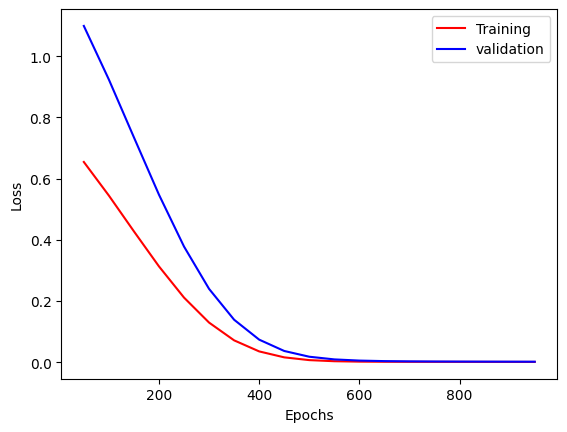

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import plotly.express as px
from dataclasses import dataclass
from utils import *
torch.manual_seed(10)



input_size = 2
learning_rate = 1e-3
max_iters = 1000
dataset_size = 16
batch_size = dataset_size


iters = []
loss_value = []
val_loss_value = []


def sample_data(split = 'train', batch_size = batch_size):
    if split != 'train':
        curr_data = validation_dataset
    else:
        curr_data = training_dataset
    curr_data = curr_data[torch.randperm(curr_data.shape[0])][:batch_size]
    a, b = curr_data.shape
    
    sparsity_vector = torch.rand(a, b)
    sparsity_mat = torch.bernoulli(torch.full((a, b), 1.0) * sparsity_vector)
    
    # X = curr_data * sparsity_mat
    X = curr_data
    return X



DEVICE = torch.device('cpu')

@dataclass
class Config:
    input_size : int
    hidden_size : int = 2
    layers : int = 2

class Two_Two(nn.Module):
    def __init__(self, hidden_size) -> None:
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(hidden_size,hidden_size), nn.Linear(hidden_size,hidden_size) )
    
    def forward(self, idx):
        return self.layers(idx)

class Model(nn.Module):
    def __init__(self, config : Config) -> None:
        super().__init__()
        self.config = config
        self.layers = nn.Sequential(
                        nn.Linear(config.input_size, config.hidden_size, bias= False),
                        #nn.ReLU(),
                        nn.Linear(config.hidden_size, 1, bias= False),
                    )

    
    def forward(self, idx : torch.Tensor):
        count = self.layers(idx) 

        loss = nn.MSELoss()
        
        return count, ((idx.sum(-1) - count.squeeze(-1))**2).mean()


training_dataset = torch.rand(dataset_size, input_size)
validation_dataset = torch.rand(int(dataset_size/2), input_size)
output = input


model = Model(Config(input_size= input_size))

def get_accuracy():
    a= sample_data(split = 'val', batch_size= 1024)
    n = (model(a)[0].argmax(-1) == (a>0).sum(-1))
    print("val accuracy",n.sum()/a.shape[0])
optimizer = torch.optim.Adam(model.parameters() , learning_rate)
start_time = time.time()
step_value = max_iters/20
for i in range(1, max_iters):
    X =  sample_data()
    count, loss = model(X)
   
    if i%step_value ==0 :
        model.eval()
        with torch.no_grad():
            X_V = sample_data(split = 'val')
            _, val_loss= model(X_V)
            iters.append(i)
            loss_value.append(loss.item())
            val_loss_value.append(val_loss.item())
            print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
        model.train()

    optimizer.zero_grad(set_to_none=True)
    #loss+= get_l1_penalty()
    loss.backward()
    optimizer.step()


end_time = time.time()
print(f"Took {end_time-start_time}s for {max_iters} epochs")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(iters,loss_value, color='red', label="Training")
plt.plot(iters, val_loss_value, "blue", label = "validation")


plt.legend()
plt.show()

In [90]:
print(model.layers[0].weight, model.layers[-1].weight)

Parameter containing:
tensor([[-0.9733, -0.4169],
        [-0.0376,  1.1518]], requires_grad=True) Parameter containing:
tensor([[-0.9346,  0.6133]], requires_grad=True)


In [125]:
X = sample_data()
for i in range(10):
    print(X[i], X[i].sum(), model(X[i]))

tensor([0.6150, 0.4967]) tensor(1.1117) (tensor([1.0897], grad_fn=<SqueezeBackward4>), tensor(0.0005, grad_fn=<MeanBackward0>))
tensor([0.0310, 0.7192]) tensor(0.7502) (tensor([0.8158], grad_fn=<SqueezeBackward4>), tensor(0.0043, grad_fn=<MeanBackward0>))
tensor([0.6959, 0.9849]) tensor(1.6808) (tensor([1.6965], grad_fn=<SqueezeBackward4>), tensor(0.0002, grad_fn=<MeanBackward0>))
tensor([0.0687, 0.0501]) tensor(0.1188) (tensor([0.1158], grad_fn=<SqueezeBackward4>), tensor(8.8702e-06, grad_fn=<MeanBackward0>))
tensor([0.8067, 0.8379]) tensor(1.6445) (tensor([1.6336], grad_fn=<SqueezeBackward4>), tensor(0.0001, grad_fn=<MeanBackward0>))
tensor([0.6178, 0.3304]) tensor(0.9482) (tensor([0.9098], grad_fn=<SqueezeBackward4>), tensor(0.0015, grad_fn=<MeanBackward0>))
tensor([0.2139, 0.4118]) tensor(0.6258) (tensor([0.6411], grad_fn=<SqueezeBackward4>), tensor(0.0002, grad_fn=<MeanBackward0>))
tensor([0.4581, 0.4829]) tensor(0.9409) (tensor([0.9354], grad_fn=<SqueezeBackward4>), tensor(3.0690

In [126]:
model(torch.tensor([3.0, 5.0]))

(tensor([8.1404], grad_fn=<SqueezeBackward4>),
 tensor(0.0197, grad_fn=<MeanBackward0>))

In [127]:
imshow(model.layers[0].weight.T)

In [96]:
imshow(model.layers[-1].weight.T)

In [103]:
model.layers[-1].weight @ model.layers[0].weight

tensor([[0.8866, 1.0961]], grad_fn=<MmBackward0>)